<a href="https://colab.research.google.com/github/NajlaZuhir/Financial-Distress-Predictor/blob/main/V1_MLZoomCamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import joblib
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score



**Following CRISP-DM**
- Step 1: Business Understanding
- Step 2: Data Understanding

### Step 3: Data preparation

In [ ]:
df = pd.read_csv('Financial Distress.csv')
df.head()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


**Encoding the target variable**

In [ ]:
df['Financial Distress'] = np.where(df['Financial Distress'] > -0.5, 'Distressed', 'Not Distressed')

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the 'Financial Distress' column
df['Financial Distress'] = le.fit_transform(df['Financial Distress'])

In [ ]:
df.head()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,0,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,0,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,1,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,0,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


# Step 4: Modeling

Feature discovery & Selection - Extracting importance features

**Note:** Due to anonymized variables, feature selection relied on model-based importance rather than domain semantics.

In [ ]:
X = df.loc[:, "x1":"x83"]
y = df["Financial Distress"]   # already binary


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [ ]:
lr_full = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear"
)

lr_full.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [ ]:
feature_importance = pd.Series(
    np.abs(lr_full.coef_[0]),
    index=X.columns
).sort_values(ascending=False)


In [ ]:
f1_scores = []
accuracy_scores = []
feature_counts = range(1, len(feature_importance) + 1)

for k in feature_counts:
    top_features = feature_importance.index[:k]

    cols_idx = [X.columns.get_loc(f) for f in top_features]

    X_train_k = X_train_scaled[:, cols_idx]
    X_val_k = X_val_scaled[:, cols_idx]

    model = LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    )

    model.fit(X_train_k, y_train)
    y_pred = model.predict(X_val_k)

    f1_scores.append(f1_score(y_val, y_pred, average="macro"))
    accuracy_scores.append(accuracy_score(y_val, y_pred))


In [ ]:
results_df = pd.DataFrame({
    "num_features": feature_counts,
    "f1_macro": f1_scores,
    "accuracy": accuracy_scores
})


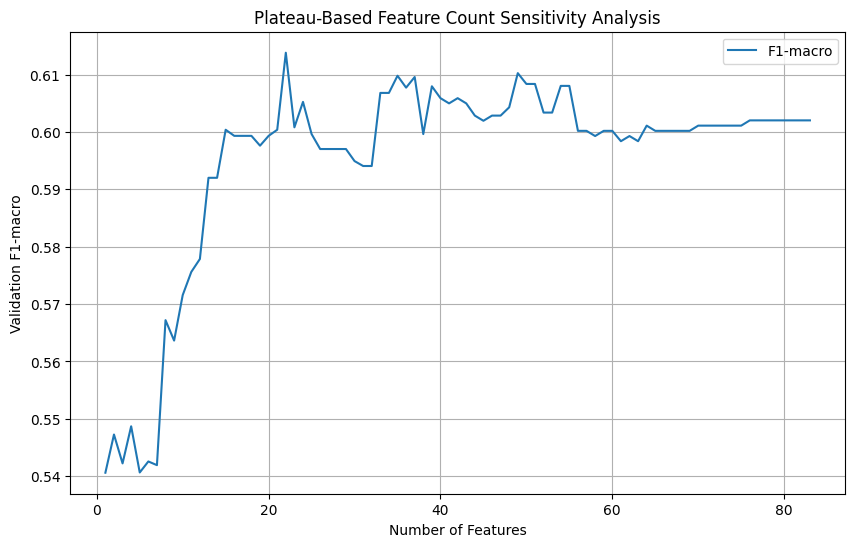

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results_df["num_features"], results_df["f1_macro"], label="F1-macro")
plt.xlabel("Number of Features")
plt.ylabel("Validation F1-macro")
plt.title("Plateau-Based Feature Count Sensitivity Analysis")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
results_df["delta_f1"] = results_df["f1_macro"].diff()

threshold = 0.005
window = 5
plateau_point = None

for i in range(len(results_df) - window):
    if results_df["delta_f1"].iloc[i+1:i+window+1].abs().max() < threshold:
        plateau_point = results_df["num_features"].iloc[i]
        break

plateau_point


np.int64(15)

In [ ]:
optimal_features = feature_importance.index[:plateau_point]
optimal_features


Index(['x36', 'x26', 'x54', 'x48', 'x51', 'x77', 'x7', 'x10', 'x72', 'x20',
       'x29', 'x44', 'x3', 'x13', 'x25'],
      dtype='object')

Final Model Training with Frozen Features

In [ ]:
# -------------------------------
# 0️⃣ Imports
# -------------------------------


# -------------------------------
# 1️⃣ Select features and target
# -------------------------------
X = df[optimal_features]  # 15 selected features from plateau analysis
y = df['Financial Distress']

# -------------------------------
# 2️⃣ Train / Validation / Test Split
# -------------------------------
# Step 1: Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Temp → Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# -------------------------------
# 3️⃣ Feature Scaling
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# 4️⃣ Train Logistic Regression
# -------------------------------
log_reg_model = LogisticRegression(
    max_iter=5000,
    random_state=42,
    class_weight='balanced',  # handle imbalance
    solver='liblinear'
)

log_reg_model.fit(X_train_scaled, y_train)

Training set size: 2937 samples
Validation set size: 367 samples
Test set size: 368 samples


LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42,
                   solver='liblinear')

# step 5: Evaluation

In [ ]:
# -------------------------------
# 5️⃣ Evaluate Model
# -------------------------------

def evaluate_model(model, X, y, dataset_name="Dataset"):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='macro')
    print(f"\n--- {dataset_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-macro: {f1:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
    print("Classification Report:\n", classification_report(y, y_pred))
    return acc, f1

# Validation
val_acc, val_f1 = evaluate_model(log_reg_model, X_val_scaled, y_val, "Validation Set")

# Test
test_acc, test_f1 = evaluate_model(log_reg_model, X_test_scaled, y_test, "Test Set")


--- Validation Set ---
Accuracy: 0.8256
F1-macro: 0.5785
Confusion Matrix:
 [[292  62]
 [  2  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90       354
           1       0.15      0.85      0.26        13

    accuracy                           0.83       367
   macro avg       0.57      0.84      0.58       367
weighted avg       0.96      0.83      0.88       367


--- Test Set ---
Accuracy: 0.8152
F1-macro: 0.5776
Confusion Matrix:
 [[288  66]
 [  2  12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89       354
           1       0.15      0.86      0.26        14

    accuracy                           0.82       368
   macro avg       0.57      0.84      0.58       368
weighted avg       0.96      0.82      0.87       368



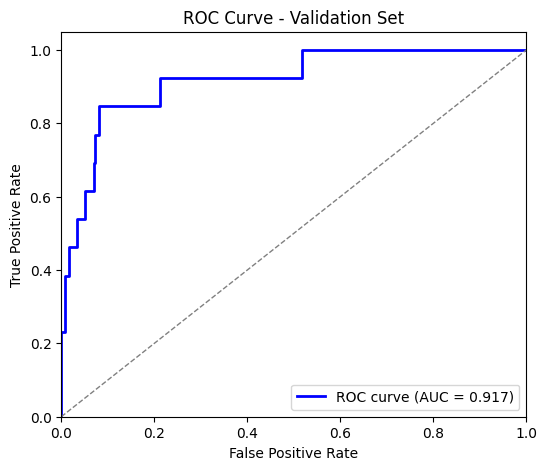

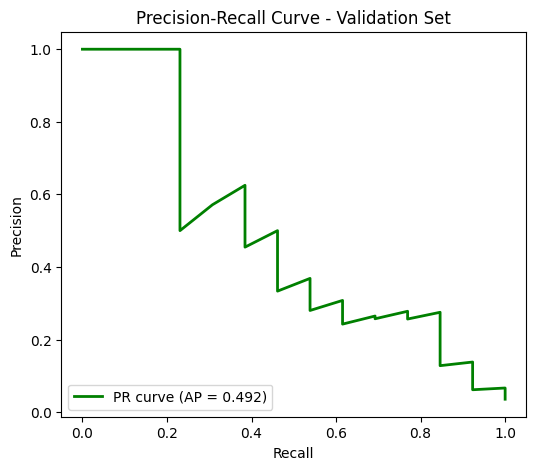

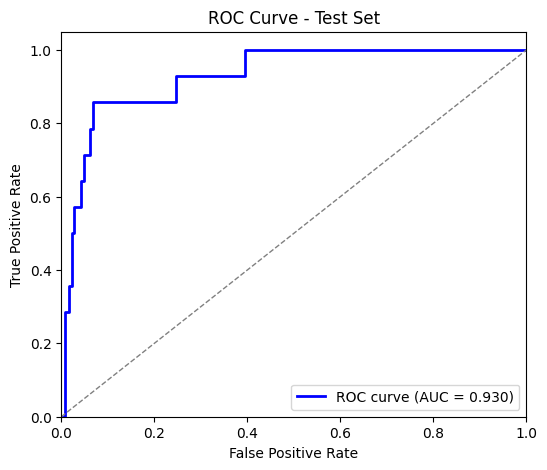

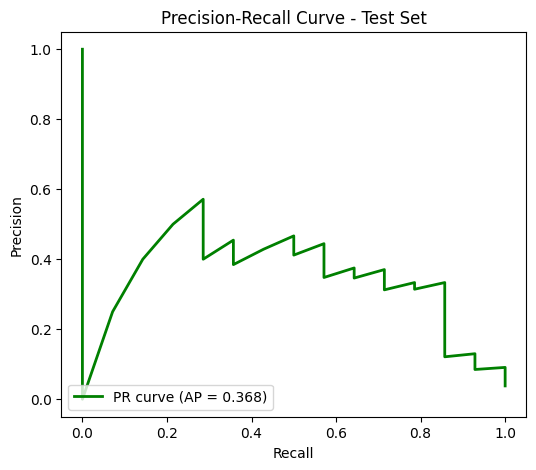

In [ ]:
# -------------------------------
# 7️⃣ ROC Curve & Precision-Recall Curve
# -------------------------------

# Get predicted probabilities for the positive class
y_val_proba = log_reg_model.predict_proba(X_val_scaled)[:, 1]
y_test_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]

# --- ROC Curve ---
def plot_roc(y_true, y_proba, dataset_name="Dataset"):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

# --- Precision-Recall Curve ---
def plot_precision_recall(y_true, y_proba, dataset_name="Dataset"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    avg_precision = average_precision_score(y_true, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {avg_precision:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {dataset_name}')
    plt.legend(loc="lower left")
    plt.show()

# Plot for Validation set
plot_roc(y_val, y_val_proba, "Validation Set")
plot_precision_recall(y_val, y_val_proba, "Validation Set")

# Plot for Test set
plot_roc(y_test, y_test_proba, "Test Set")
plot_precision_recall(y_test, y_test_proba, "Test Set")


# Step 6: Deployment

Saving / MLOps Prep

In [ ]:

# -------------------------------
# 6️⃣ Save Model, Scaler, and Feature List
# -------------------------------
joblib.dump(log_reg_model, "financial_distress_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(optimal_features, "selected_features.pkl")

print("\nModel, scaler, and feature list saved successfully ✅")

**Next Steps:**
- use flask to turn teh model into a webservice
- use a dependancy & env mager
- package it in Docker
- deploy to cloud